iris.csv downloaded and saved!


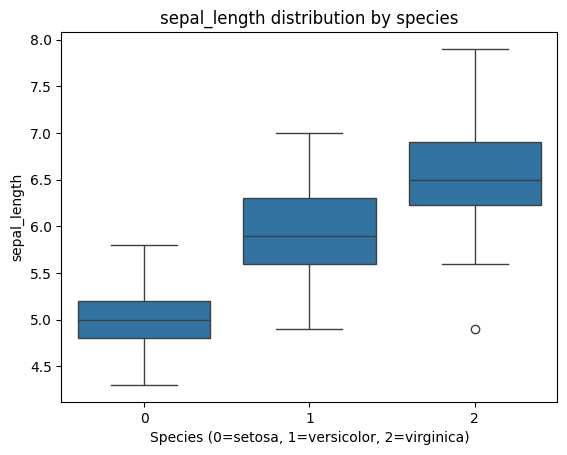

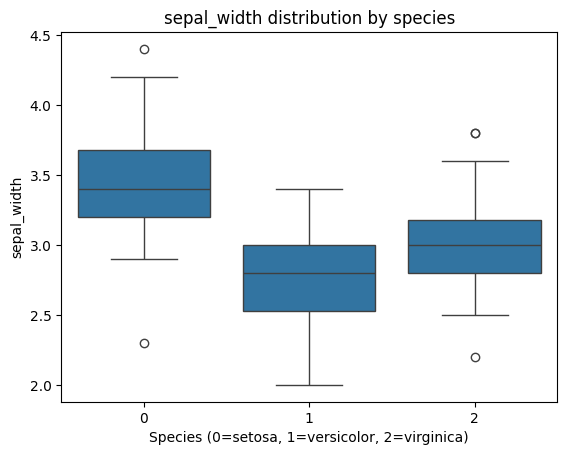

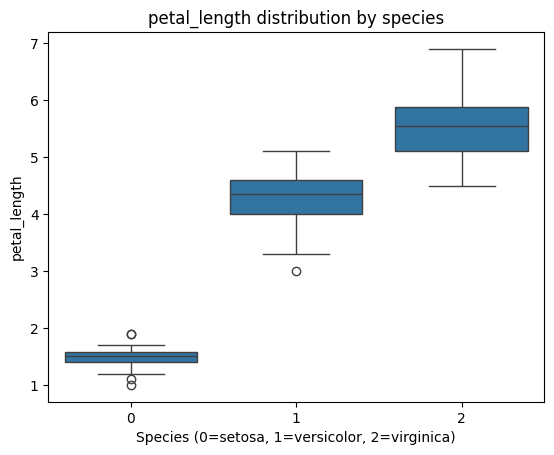

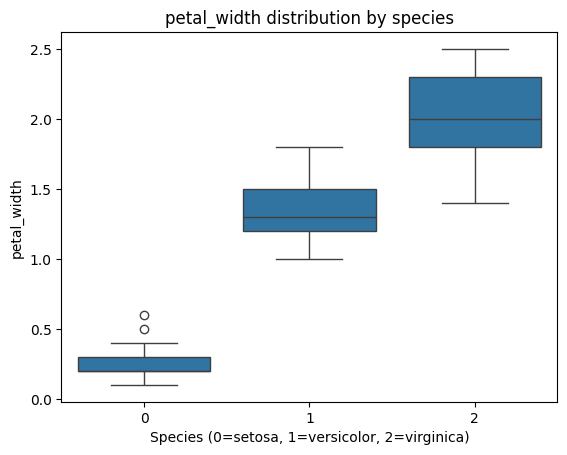

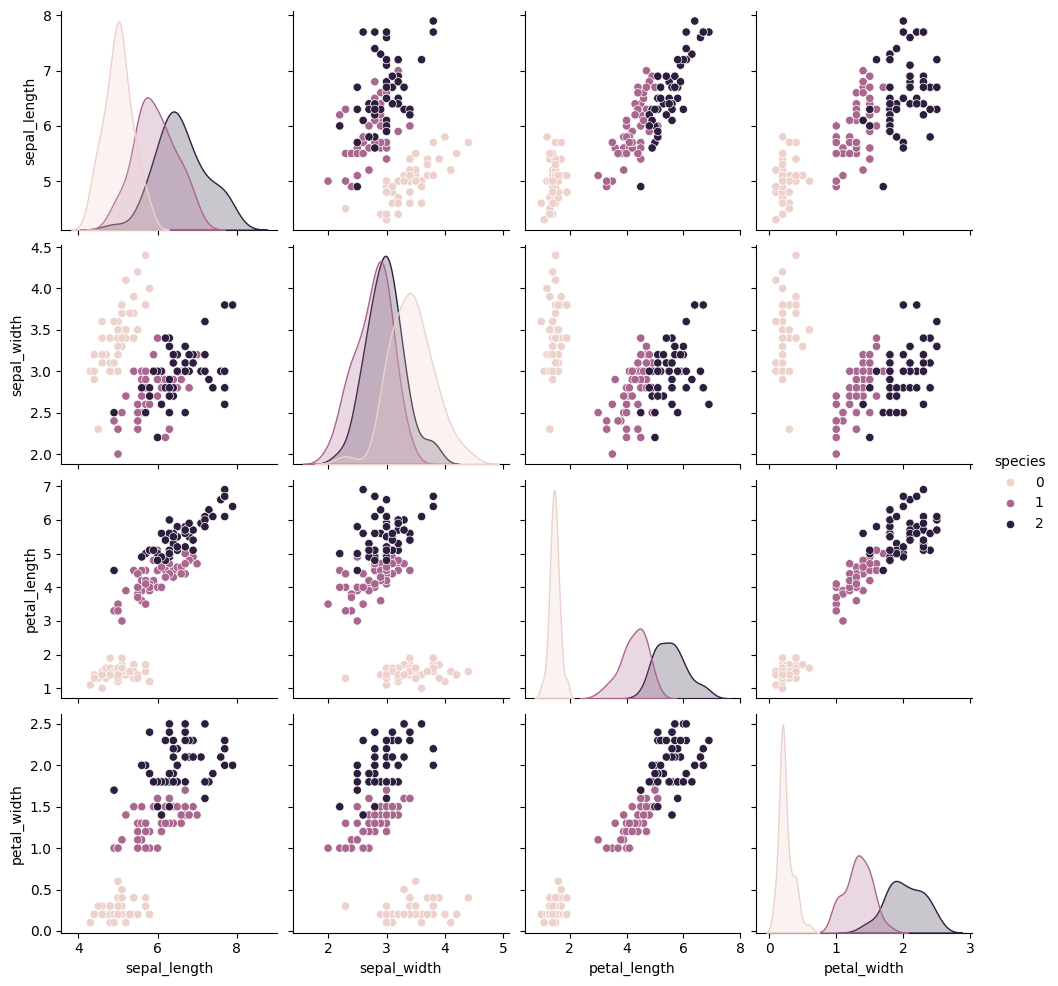

Epoch 10 | Train Loss: 0.1704, Acc: 0.9500 | Test Loss: 0.2201, Acc: 0.9000
Epoch 20 | Train Loss: 0.0655, Acc: 0.9750 | Test Loss: 0.1074, Acc: 0.9667
Epoch 30 | Train Loss: 0.0490, Acc: 0.9750 | Test Loss: 0.0892, Acc: 0.9667
Epoch 40 | Train Loss: 0.0509, Acc: 0.9833 | Test Loss: 0.0895, Acc: 0.9333
Epoch 50 | Train Loss: 0.0411, Acc: 0.9833 | Test Loss: 0.0860, Acc: 0.9667
Epoch 60 | Train Loss: 0.0375, Acc: 0.9833 | Test Loss: 0.0792, Acc: 0.9667
Epoch 70 | Train Loss: 0.0518, Acc: 0.9833 | Test Loss: 0.0830, Acc: 0.9667
Epoch 80 | Train Loss: 0.0345, Acc: 0.9833 | Test Loss: 0.0771, Acc: 0.9667
Epoch 90 | Train Loss: 0.0356, Acc: 0.9833 | Test Loss: 0.0828, Acc: 0.9667
Epoch 100 | Train Loss: 0.0345, Acc: 0.9833 | Test Loss: 0.0819, Acc: 0.9667


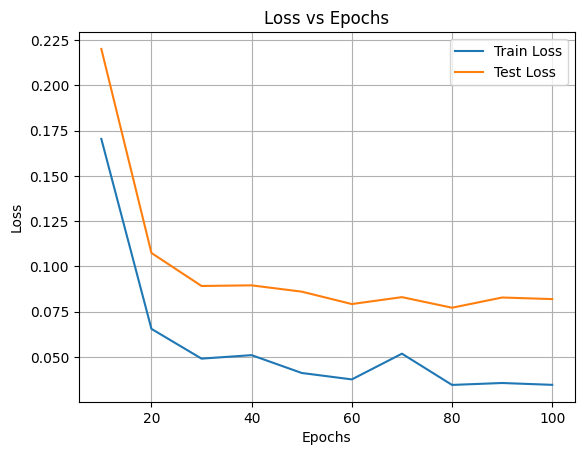

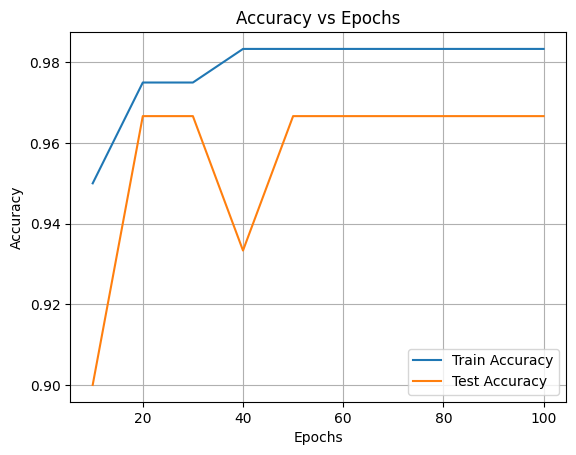

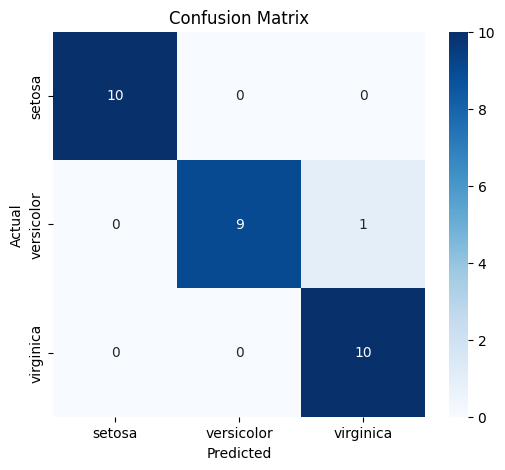

In [3]:
#Q1 : Neural Network with PyTorch - Classifying Iris Flowers
#1.0: Dataset - Iris Dataset
import pandas as pd
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv"
df = pd.read_csv(url)
df.to_csv("iris.csv", index=False)
print("iris.csv downloaded and saved!")
df = pd.read_csv('iris.csv')

#1.1: Load and Preprocess the Data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('iris.csv')

# Encode target column
le = LabelEncoder()
df['species'] = le.fit_transform(df['species'])  # setosa=0, versicolor=1, virginica=2

# Split features and labels
X = df.drop('species', axis=1).values
y = df['species'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data  = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=16)

#1.2: Visualize the Data
# Box plots
features = df.columns[:-1]
for feature in features:
    plt.figure()
    sns.boxplot(data=df, x='species', y=feature)
    plt.title(f'{feature} distribution by species')
    plt.xlabel('Species (0=setosa, 1=versicolor, 2=virginica)')
    plt.show()

# Optional: pairplot
sns.pairplot(df, hue='species')
plt.show()

#1.3: Build the Neural Network
import torch.nn as nn

class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 3)  # 3 output classes

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = IrisNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#1.4: Train the Model
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

def evaluate(loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    return total_loss / len(loader), correct / total

for epoch in range(1, 101):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        train_loss, train_acc = evaluate(train_loader)
        test_loss, test_acc = evaluate(test_loader)
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

#1.5: Create Plots
#1.5.1 - Loss vs Epochs
epochs = range(10, 101, 10)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

#1.5.2 - Accuracy vs Epochs
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

#1.5.3 - Final Confusion Matrix
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, preds = torch.max(outputs, 1)

cm = confusion_matrix(y_test, preds.numpy())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [2]:
#Q2 : Optical Extension - Understanding and Implementing Backpropagation from Scratch
#2.1: Understand the Theory of Backpropagation
#Forward Pass
#Loss Calculation
#Backward Pass
#Weight Update Rule

#2.2: Implement Backpropagation from Scratch
import numpy as np

# Sigmoid and its derivative
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Loss Function: Binary Cross-Entropy
def binary_cross_entropy(y_true, y_pred):
    return -np.mean(y_true*np.log(y_pred+1e-8) + (1-y_true)*np.log(1-y_pred+1e-8))

# Data: XOR
X = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([[0],[1],[1],[0]])

# Initialize weights and biases
np.random.seed(42)
W1 = np.random.randn(2, 2)
b1 = np.zeros((1, 2))
W2 = np.random.randn(2, 1)
b2 = np.zeros((1, 1))

# Hyperparameters
lr = 0.1
epochs = 10000

for epoch in range(epochs):
    # FORWARD PASS
    z1 = np.dot(X, W1) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = sigmoid(z2)

    # LOSS
    loss = binary_cross_entropy(y, a2)

    # BACKWARD PASS
    d_loss_a2 = a2 - y                     # derivative of loss w.r.t a2
    d_a2_z2 = sigmoid_derivative(z2)
    d_z2_W2 = a1

    dW2 = np.dot(d_z2_W2.T, d_loss_a2 * d_a2_z2)
    db2 = np.sum(d_loss_a2 * d_a2_z2, axis=0, keepdims=True)

    d_z2_a1 = W2
    d_a1_z1 = sigmoid_derivative(z1)

    dW1 = np.dot(X.T, (np.dot(d_loss_a2 * d_a2_z2, d_z2_a1.T) * d_a1_z1))
    db1 = np.sum((np.dot(d_loss_a2 * d_a2_z2, d_z2_a1.T) * d_a1_z1), axis=0, keepdims=True)

    # WEIGHT UPDATE
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2

    # Print loss occasionally
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

#2.3: Compare with PyTorch’s Built-in Backpropagation
import torch
import torch.nn as nn
import torch.optim as optim

# Data
X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.float32)

# Model
model = nn.Sequential(
    nn.Linear(2, 2),
    nn.Sigmoid(),
    nn.Linear(2, 1),
    nn.Sigmoid()
)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(10000):
    # Forward
    outputs = model(X_t)
    loss = criterion(outputs, y_t)

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
#If implemented correctly, both models will have similar results.

#2.4: Experiment with Different Learning Rates
#Change (lr = 0.1) to different values
#lr = 0.01: slower learning, may not converge well
#lr = 0.1: balanced
#lr = 1.0: might overshoot or diverge
#Observation -
#Very small lr: slow convergence
#Very large lr: possible divergence or oscillations

Epoch 0, Loss: 0.7049
Epoch 1000, Loss: 0.6920
Epoch 2000, Loss: 0.6840
Epoch 3000, Loss: 0.5989
Epoch 4000, Loss: 0.4697
Epoch 5000, Loss: 0.4222
Epoch 6000, Loss: 0.4023
Epoch 7000, Loss: 0.3916
Epoch 8000, Loss: 0.3848
Epoch 9000, Loss: 0.3801
Epoch 0, Loss: 0.6939
Epoch 1000, Loss: 0.6932
Epoch 2000, Loss: 0.6930
Epoch 3000, Loss: 0.6925
Epoch 4000, Loss: 0.6909
Epoch 5000, Loss: 0.6798
Epoch 6000, Loss: 0.5976
Epoch 7000, Loss: 0.4817
Epoch 8000, Loss: 0.4159
Epoch 9000, Loss: 0.3877
